## Tennis_match_outcomes_prediction by BARECHE Yassine

In [74]:
# Imports :

from time import time

from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob

import random
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics as mts
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, classification_report, log_loss


from keras import models, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import metrics
from keras.models import load_model


logging.getLogger().setLevel('INFO')

## Helpers

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Chargement des données : 

In [3]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))


df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

In [4]:
df_atp.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63,77,6.0,4.0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Clement A.,5,56,6.0,3.0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,40,655,6.0,7.0,7,5,6,3,NaN,NaN,NaN,NaN,2.0,1,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,Knippschild J.,65,87,6.0,1.0,6,4,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,81,198,7.0,6.0,5,7,6,4,NaN,NaN,NaN,NaN,2.0,1,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_atp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52298 entries, 0 to 52297
Data columns (total 54 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         52298 non-null  int64         
 1   Location    52298 non-null  object        
 2   Tournament  52298 non-null  object        
 3   Date        52298 non-null  datetime64[ns]
 4   Series      52298 non-null  object        
 5   Court       52298 non-null  object        
 6   Surface     52298 non-null  object        
 7   Round       52298 non-null  object        
 8   Best of     52298 non-null  int64         
 9   Winner      52298 non-null  object        
 10  Loser       52298 non-null  object        
 11  WRank       52283 non-null  object        
 12  LRank       52220 non-null  object        
 13  W1          52035 non-null  float64       
 14  L1          52037 non-null  float64       
 15  W2          51526 non-null  object        
 16  L2          51527 non-

## Requetes diverses :

### **Req 1 : les trois joueurs ATP avec le plus de victoires**

In [6]:
df_atp.groupby("Winner").size().sort_values(ascending=False).head(3)

Winner
Federer R.     1121
Nadal R.        891
Djokovic N.     802
dtype: int64

### **Req 2 : Le nombre total  d'ensembles reportés par le joueur "Federer R"**

In [7]:
# Matchs de federer ---> on s'intéresses au Wsets et Lsets
df_federer_winner = df_atp[df_atp["Winner"]=="Federer R."]
df_federer_loser =  df_atp[df_atp["Loser"]=="Federer R."]

# Verification des valeurs de Wsets(float64) et Lsets(object ! risque de valeurs non conformes : NaN,string .. etc )
print("Valeurs Uniques dans Lsets : ",df_federer_loser["Lsets"].unique()) 
print("Valeurs Uniques dans Wsets : ",df_federer_winner['Wsets'].unique())


Valeurs Uniques dans Lsets :  [0 1 2 '`1' nan]
Valeurs Uniques dans Wsets :  [ 2.  3.  1.  0. nan]


In [8]:
# Sum skiping null/nan "`" and string values in Lsets
skiped= df_federer_loser["Lsets"].replace('`1',1)
sets_federer = int(df_federer_winner["Wsets"].sum(skipna=True)) + int(skiped.sum(skipna=True)) 
print("\nNombre total des ensembles gagnés par Federer R. est = ",sets_federer)



Nombre total des ensembles gagnés par Federer R. est =  2696


### **Req3 : Le nombre d'ensembles reportées par le joueur "Federer R" entre 2016 et 2017**

In [9]:
df_federer_winner_16_17 = df_federer_winner[(df_federer_winner["Date"].dt.year == 2016) |
                                            (df_federer_winner["Date"].dt.year == 2017)]

df_federer_loser_16_17 = df_federer_loser[(df_federer_loser["Date"].dt.year == 2016) |
                                          (df_federer_loser["Date"].dt.year == 2017)]


skiped_16_17= df_federer_loser_16_17["Lsets"].replace('`1',1)

sets_16_17= int(df_federer_winner_16_17["Wsets"]
                .sum(skipna=True)) + int(skiped_16_17.sum(skipna=True))



print("Le nombre d'ensembles reportés par Federer R pendant 2016/2017 est : ",sets_16_17)                

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Le nombre d'ensembles reportés par Federer R pendant 2016/2017 est :  182


### **Req 4 : Pour chaque macth le pourcentage des victoires du vainqueur pendant les matchs précédents**

Cette requète est couteuse en temps de calcul, on propose donc de paralleliser le traitment en utilsant **pandaparallel**

In [10]:
!pip install pandarallel 

  Created wheel for pandarallel: filename=pandarallel-1.5.1-cp36-none-any.whl size=17127 sha256=b221037239af2ddfee332a7642c5c24989711f8af2c801508d68a570540a5c12
  Stored in directory: /root/.cache/pip/wheels/6f/c8/e5/d43fa63105ce1dd22f4df51bc2edfefd54d92ce64f25326314
Successfully built pandarallel


In [11]:
from pandarallel import pandarallel
# Initialization
pandarallel.initialize(nb_workers=5)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
def prior_wins_percent(df_atp, player, date, minimum_played_games = 1):

  df_previous  = df_atp[df_atp["Date"] < date]
  previous_wins = df_previous[df_previous["Winner"] == player].shape[0]
  previous_losses = df_previous[df_previous["Loser"] == player].shape[0]

  if  minimum_played_games > (previous_wins + previous_losses): # un minimum de match est requis pour éviter des pourcentage elevé (en début de carriere professionnel par exemple)
      return 0
  return previous_wins / (previous_wins + previous_losses)

In [13]:
df_atp["prior_wins_winner"]=df_atp.parallel_apply(
    lambda row: prior_wins_percent(df_atp, row["Winner"], row["Date"] ),
    axis=1
)


In [14]:
df_atp["prior_wins_loser"]=df_atp.parallel_apply(
    lambda row: prior_wins_percent(df_atp, row["Loser"], row["Date"] ),
    axis=1
)


In [ ]:
df_atp.to_csv("atp_prior_wins_percentage.csv")
#df_atp=pd.read_csv("atp_prior_wins_percentage.csv")
#df_atp.head()

## Préparation des données :

### **Annotation : ajout des labels**



*   Si nous définissons le résultat d'un match ATP comme le «nom du vinqueur», le problème serait une tâche **multi-classification** avec une sortie prenant des étiquettes appartenant aux noms de tous les joueurs depuis 2000. Cette approche **«naïve»** n'est pas réaliste puisque pour chaque match, nous avons deux joueurs et le vainqueur est parmi eux. 



*   Une façon d'explorer cela est de considérer  les 2 joueurs participant à un match : "joueur 1" et "joueur 2" auxquelles nous attribuons le vainqueur et le perdant du match, la variable cible = **"target"** appartiendrait au couple (0,1) et donc le problème peut être traité comme un problème de **classification binaire.**



Afin d'éviter le **biais** sur **les labels**, je propose une logique selon laquelle nous appellerons le joueur 1 et le joueur 2 selon l'ordre léxéographique (ordre alphanumérique )(Relation d'ordre total ROT) de leurs noms et remplirons la variable de sortie (label) en conséquence.

Joueur1 est celui dont le nom est plus petit.


*   Si joueur 1 gagne alors label = 1
*   Si joueur 2 gagne alors label = 0


    


In [16]:
df_atp["Labs"] = df_atp.apply(lambda row: 1 if row["Winner"] < row["Loser"] else 0, axis=1)
df_atp[["Winner", "Loser", "Labs"]].head(5)

,Winner,Loser,Labs
0,Dosedel S.,Ljubicic I.,1
1,Enqvist T.,Clement A.,0
2,Escude N.,Baccanello P.,0
3,Federer R.,Knippschild J.,1
4,Fromberg R.,Woodbridge T.,1


In [17]:
print("Effectif de la classe 1 : {}".format(df_atp[df_atp["Labs"] == 1].shape[0]))
print("Effectif de la classe 0 : {}".format(df_atp[df_atp["Labs"] == 0].shape[0]))

Effectif de la classe 1 : 26602
Effectif de la classe 0 : 25696


### **Gestion des entrées défectueuses :**

In [18]:
df_atp.describe(include=['O'])

,Location,Tournament,Series,Court,Surface,Round,Winner,Loser,WRank,LRank,W2,L2,W3,L3,Lsets,Comment,EXW
count,52298,52298,52298,52298,52298,52298,52298,52298,52283,52220,51526.0,51527.0,24169.0,24168.0,52073,52298,39411.00
unique,115,214,8,2,4,8,948,1483,604,943,9.0,9.0,9.0,9.0,4,5,356.00
top,Paris,Australian Open,International,Outdoor,Hard,1st Round,Federer R.,Lopez F.,1,46,6.0,6.0,6.0,4.0,0,Completed,1.35
freq,3306,2413,12204,42941,27716,24212,1121,415,1172,464,33924.0,12516.0,17187.0,5412.0,32647,50358,1321.00


Certaines colonnes ont été converties à tort en Object au lieu de float64 ou int64.

Commençons par vérifier le problème avec les colonnes avec quelques uniques.

In [19]:
df_atp['L2'].unique()

array([2.0, 3.0, 5.0, 4.0, 7.0, 6.0, 1.0, 0.0, nan, ' '], dtype=object)

Certaines entrées de la colonne L2 ont la valeur " ", qui ne peut pas être convertie en flot. Ainsi, la colonne entière est convertie en object.

Corrigeons cela en changeant ces entrées '' en NaN:


In [20]:
df_atp.loc[df_atp.L2 == ' ', ['L2']] = np.nan
df_atp.L2.unique()

array([2.0, 3.0, 5.0, 4.0, 7.0, 6.0, 1.0, 0.0, nan], dtype=object)

Le meme probleme se répète avec les colonnes L3, W2 et W3, on le fixe de la meme manière. Et comme remarqué précedement Lsets a un problème aussi on trouve '`1'à la place de 1

In [21]:
print('L3 uniques avant: ', df_atp.L3.unique())
print('W2 uniques avant: ', df_atp.W2.unique())
print('W3 uniques avant: ', df_atp.W3.unique())
print("Lsets uniques avant :", df_atp.Lsets.unique())

df_atp.loc[df_atp.L3 == ' ', ['L3']] = np.nan
df_atp.loc[df_atp.W2 == ' ', ['W2']] = np.nan
df_atp.loc[df_atp.W3 == ' ', ['W3']] = np.nan
df_atp.loc[df_atp.Lsets == '`1', ['Lsets']] = 1 

print("*" * 80)

print('L3 uniques after fixing: ', df_atp.L3.unique())
print('W2 uniques after fixing: ', df_atp.W2.unique())
print('W3 uniques after fixing: ', df_atp.W3.unique())
print("Lsets uniques après:", df_atp.Lsets.unique())

L3 uniques avant:  [nan 3.0 4.0 1.0 2.0 6.0 0.0 5.0 7.0 ' ']
W2 uniques avant:  [6.0 7.0 5.0 2.0 4.0 nan 0.0 3.0 1.0 ' ']
W3 uniques avant:  [nan 6.0 7.0 3.0 1.0 4.0 2.0 5.0 0.0 ' ']
Lsets uniques avant : [0 1 2 nan '`1']
********************************************************************************
L3 uniques after fixing:  [nan 3.0 4.0 1.0 2.0 6.0 0.0 5.0 7.0]
W2 uniques after fixing:  [6.0 7.0 5.0 2.0 4.0 nan 0.0 3.0 1.0]
W3 uniques after fixing:  [nan 6.0 7.0 3.0 1.0 4.0 2.0 5.0 0.0]
Lsets uniques après: [0 1 2 nan]


Maintenant, la colonne LRank (WRank éventuellment). C'est plus compliqué car il y a 943 valeurs uniques, donc je ne peux pas simplement les imprimer et rechercher la faute de frappe.

Donc, écrivons une fonction pour vérifier si une valeur ne peut pas être convertie en float. Appliquez cette fonction à chaque entrée de la colonne LRank/WRank, on utilise les résultats pour filtrer dans la colonne et obtenir les entrées défectueuses.

In [22]:
def isnotfloat(value):
  try:
    float(value)
    return False
  except ValueError:
    return True

df_atp.LRank[list(map(lambda x: isnotfloat(x), df_atp.LRank))]

63      NR
377     NR
560     NR
611     NR
613     NR
618     NR
774     NR
1039    NR
1694    NR
1849    NR
3540    NR
3551    NR
4457    NR
5435    NR
5487    NR
5491    NR
5494    NR
5498    NR
5528    NR
5998    NR
6307    NR
6777    NR
7296    NR
7414    NR
7418    NR
8111    NR
9596    NR
Name: LRank, dtype: object

In [23]:
df_atp.WRank[list(map(lambda x: isnotfloat(x), df_atp.WRank))]

744    NR
Name: WRank, dtype: object

In [24]:
df_atp.EXW[list(map(lambda x: isnotfloat(x), df_atp.EXW))]

38294    2.,3
Name: EXW, dtype: object

Maintenant que les entrées défectueuses sont connues, faisons exactement la même chose qu'avec les autres colonnes.

In [25]:
df_atp.loc[df_atp.LRank == 'NR', ['LRank']] = np.nan
df_atp.loc[df_atp.WRank == 'NR', ['WRank']] = np.nan
df_atp.loc[df_atp.EXW == '2.,3', ['EXW']] = np.nan

Maintenant que toutes les entrées défectueuses ont été prises en compte, convertissons ces colonnes de Object --> float64.



In [26]:
col_updated = ['L2', 'L3', 'LRank', 'WRank','EXW' ,'Lsets', 'W2', 'W3']
for w in col_updated:
  df_atp.loc[:, [w]] = np.float64(df_atp[w][:])

df_atp.describe(include=['O'])

,Location,Tournament,Series,Court,Surface,Round,Winner,Loser,Comment
count,52298,52298,52298,52298,52298,52298,52298,52298,52298
unique,115,214,8,2,4,8,948,1483,5
top,Paris,Australian Open,International,Outdoor,Hard,1st Round,Federer R.,Lopez F.,Completed
freq,3306,2413,12204,42941,27716,24212,1121,415,50358


### **Gestion des données manquantes (nan) :**

Nombre de valeurs manquantes (NaN) par chaque feature :

In [28]:
print("Taille des données : {}".format(df_atp.shape[0]))
nulls=df_atp.isnull().sum()
nulls

Taille des données : 52298


ATP                      0
Location                 0
Tournament               0
Date                     0
Series                   0
Court                    0
Surface                  0
Round                    0
Best of                  0
Winner                   0
Loser                    0
WRank                   16
LRank                  105
W1                     263
L1                     261
W2                     774
L2                     773
W3                   28228
L3                   28228
W4                   47567
L4                   47567
W5                   50507
L5                   50507
Wsets                  224
Lsets                  225
Comment                  0
CBW                  34792
CBL                  34792
GBW                  47243
GBL                  47243
IWW                  38940
IWL                  38940
SBW                  46874
SBL                  46874
B365W                 8655
B365L                 8632
B&WW                 51201
B

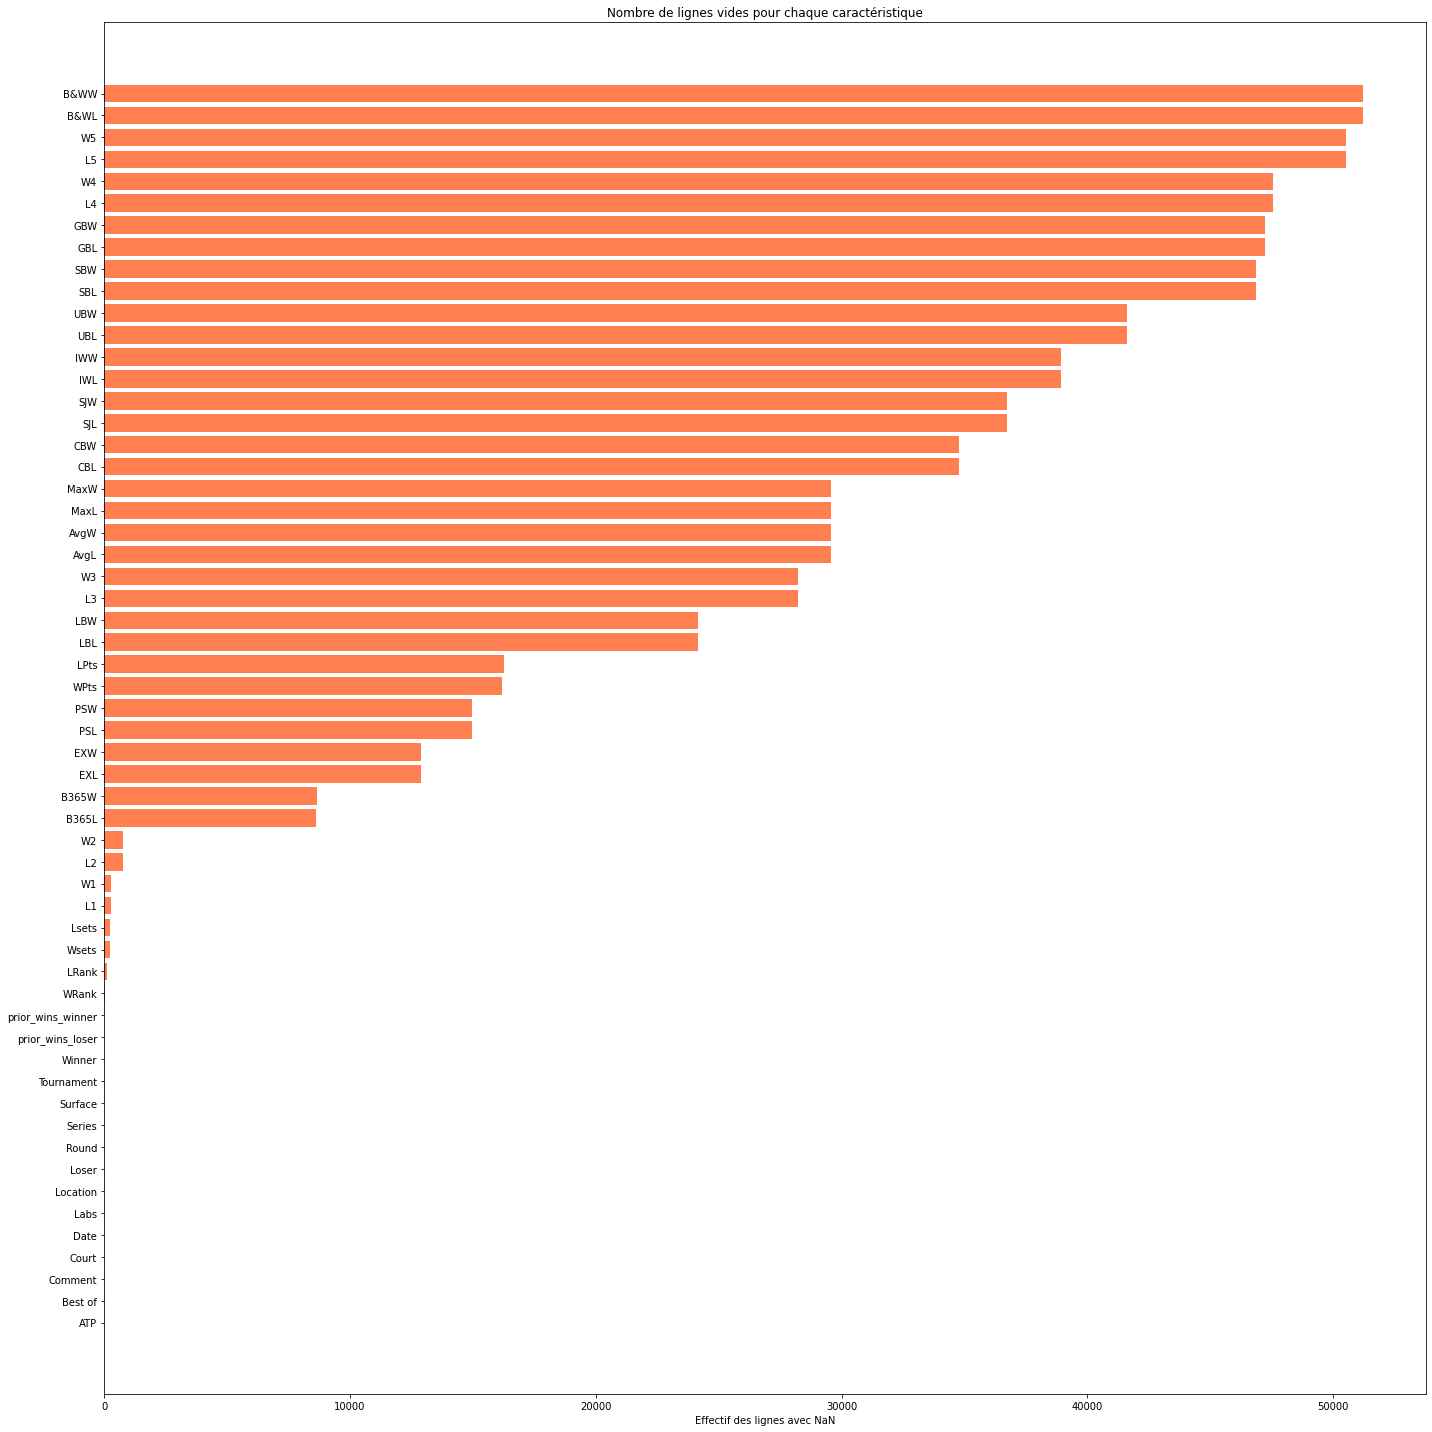

In [29]:
feat_nan, cols = zip(*sorted(zip(nulls, df_atp.columns)))
plt.figure(figsize=(20, 20))
plt.barh(range(len(cols)), feat_nan, align="center", color='coral');
plt.yticks(range(len(cols)), cols)
plt.title("Nombre de lignes vides pour chaque caractéristique")
plt.xlabel("Effectif des lignes avec NaN")
plt.tight_layout();

**Stratégie de gestion des valeurs NAN** :


Nous remplissons les valeurs NaN avec la stratégie suivante:


*   Suppréssion des champs contenant trop des champs NAN (on définit un seuil minimum soit 3/4 par exemple)

*   Le nombre de lignes avec des valeurs manquantes dans l'un des WRank, LRank est faible par rapport à la taille de l'ensemble de données, leurs suppression ne fais pas du mal mais il est possible aussi de les remplir avec la valeur de classement maximale dans chaque colonne (personellement j'opte pour la première alternative).

*  Lsets, L1, W1, L2 et W2 est faible par rapport à la taille de l'ensemble de données, et il n'y a pas de moyen facile de déduire leurs données, il serait donc possible de les supprimer.On peut les attribuer des zéros aussi si on suppose que ces cas correpondent à un retrait d'un des joueurs.(personellement j'opte pour la première alternative)

*   Presque tout le jeu de données n'a pas de valeurs pour W4, L4, W5 et L5. Cela est dû au fait que la plupart des jeux s'arretent au 3 eme tour, donc ne nécessitent pas 4 ou 5 tours, je propose alors de remplacer les NaN par des zéros, en supposant que le match est gagné avant d'arriver à cet ensemble.


*   Pour le nombre de sets gagnés lors du match Wsets et Lsets, nous supposons que les valeurs NaN correspondent à un retrait (par exemple en raison d'une blessure), nous remplaçons donc cela par des zéros ou carrement les supprimer vue qu'ils ne sont nombreux.



*    Près de la moitié de l'ensemble de données ne contient pas les valeurs pour AvgW, AvgL, MaxW et MaxL. Ces valeurs peuvent être calculées, ce n'est donc pas un gros problème. En effet, on fais des agrégations sur les *odds*  tels que : "'B365W', 'EXW', ... ect"

*    Pour les valeurs simples des *odds* comme  : "'B365W', 'EXW', ... ect", on remplace NaNs par une valeur de 1.0 qui correspond à une probabilité de gain de 50% (Pour une paire  W / L, la probabilité de gain est donnée par p = W / (W + L) = 1/2 = probabilité de perte).Mais ça depend de chaque type de cote, il y en a certains à supprimer eventuellment (ceux qui contient trop de nan)





** Completons d'abord les valeurs MaxW, MaxL, AvgW et AvgL, à partir des valeurs 'B365W', 'EXW', ... ect **

Mais on remarque par exemple que b&wL et b&wW présentent plus de 50k valeurs manquantes en pratique ces champs ne servent pas à grand chose. Donc on essaye meme pas de les inférer pour éviter le risque de biaser les données. Il est préférable donc de ne pas les consédirer. (Pareil pour GB, SB , UB et IW)




   
   
    
    



In [30]:
odds_W = ['B365W', 'EXW', 'PSW', 'LBW', 'CBW', 'SJW', 'IWW', 'UBW', 'SBW', 'GBW', 'B&WW']
odds_L = ['B365L', 'EXL', 'PSL', 'LBL', 'CBL', 'SJL', 'IWL', 'UBL', 'SBL', 'GBL', 'B&WL']

Supprimons les colones entièrement remplis par NaN

In [31]:
df_atp = df_atp.dropna(axis=1, how="all")

Puis, Pour les valeurs simples des odds comme : "'B365W', 'EXW', ... ect", soit 

*   on remplace NaNs par une valeur de 1.0 qui correspond à une probabilité de gain de 50% (Pour une paire W / L, la probabilité de gain est donnée par p = W / (W + L) = 1/2 = probabilité de perte)

*  Soit on supprime les champs ayant au plus une valeur NAN (inutile pour calculer Avg qui requiert au moins deux valeurs)



In [32]:
#df_atp.fillna({x : 1.0 for x in odds_L+odds_W}, inplace=True)

print('Nombre des entrées avant la suppression:', df_atp.shape[0])
df_atp.dropna(subset=odds_W, thresh=2, axis=0, inplace=True)
df_atp.dropna(subset=odds_L, thresh=2, axis=0, inplace=True)
print("-" * 40)
print('Data entries after dropping:', df_atp.shape[0])

Nombre des entrées avant la suppression: 52298
----------------------------------------
Data entries after dropping: 48141


In [33]:
# Compléter les valeurs manquantes de AvgW et AvgL = moyennes des "odds"
print("Valeurs manquantes pour AvgW avant MaJ:",sum(df_atp['AvgW'].isna()))
print("Valeurs manquantes pour AvgL avant MaJ:",sum(df_atp['AvgL'].isna()))

df_atp['AvgW'].fillna(df_atp[odds_W].mean(axis=1), inplace=True)
df_atp['AvgL'].fillna(df_atp[odds_L].mean(axis=1), inplace=True)

print("*" * 45)

print("Valeurs manquantes pour AvgW après MaJ:", sum(df_atp['AvgW'].isna()))
print("Valeurs manquantes pour AvgL après MaJ:",sum(df_atp['AvgL'].isna()))
print('\n')

# Compléter les valeurs manquantes pour MaxW et MaxL = max des valeurs singulières "odds"
print("Valeurs manquantes pour MaxW avant MaJ:",sum(df_atp['MaxW'].isna()))
print("Valeurs manquantes pour MaxL avant MaJ:",sum(df_atp['MaxL'].isna()))

df_atp['MaxW'].fillna(df_atp[odds_W].max(axis=1), inplace=True)
df_atp['MaxL'].fillna(df_atp[odds_L].max(axis=1), inplace=True)

print("*" * 45)

print("Valeurs manquantes pour MaxW après MaJ:", sum(df_atp['MaxW'].isna()))
print("Valeurs manquantes pour MaxL après MaJ:",sum(df_atp['MaxL'].isna()))


Valeurs manquantes pour AvgW avant MaJ: 25455
Valeurs manquantes pour AvgL avant MaJ: 25455
*********************************************
Valeurs manquantes pour AvgW après MaJ: 0
Valeurs manquantes pour AvgL après MaJ: 0


Valeurs manquantes pour MaxW avant MaJ: 25455
Valeurs manquantes pour MaxL avant MaJ: 25455
*********************************************
Valeurs manquantes pour MaxW après MaJ: 0
Valeurs manquantes pour MaxL après MaJ: 0


Comme les entrées des Wrank Et Lrank sont pas nombreaux on peut : soit

*   remplir les NaN de WRank, LRank avec la valeur de classement maximale dans chaque colonne. 

* Carement supprimer ces entrées.

In [34]:
#df_atp["WRank"] = df_atp["WRank"].fillna(df_atp["WRank"].max())
#df_atp["LRank"] = df_atp["LRank"].fillna(df_atp["LRank"].max())

print('Nombre des entrées avant la suppression:', df_atp.shape[0])
df_atp.dropna(subset=['LRank','WRank'], axis=0, inplace=True)
print("-" * 50)
print('Nombre des entrées après la suppression:', df_atp.shape[0])

Nombre des entrées avant la suppression: 48141
--------------------------------------------------
Nombre des entrées après la suppression: 48046



*    Pour le nombre de points gagnées par set, on remplace les NaN par des zéros, en supposant que le match est gagné avant d'arriver à cet ensemble

*   Pour le nombre de sets gagnés lors du match Wsets et Lsets, nous supposons que les valeurs NaN correspondent à un retrait (par exemple en raison d'une blessure), nous remplaçons donc cela par des zéros

* On peut égalment supprimer ces valeurs vue qu'ils ne sont pas nombreux.


In [35]:
sets=["L1", "L2", "L3", "L4", "L5", "W1", "W2", "W3", "W4", "W5","Wsets","Lsets"]
#df_atp.fillna({x : 0 for x in sets}, inplace=True)

print('Nombre des entrées avant la suppression:', df_atp.shape[0])
df_atp.dropna(subset=['Wsets', 'Lsets', 'L1', 'W1', 'L2', 'W2'], axis=0, inplace=True)
print("-" * 50)
print('Nombre des entrées après la suppression:', df_atp.shape[0])

Nombre des entrées avant la suppression: 48046
--------------------------------------------------
Nombre des entrées après la suppression: 47332


## Extraction et/ou Selection des caractéristiques (Feature extraction/selection):

Cette partie sert à identifier les caractéristiques (attributs) portant le plus d'information (les plus discriminiantes ) et qui ne présentent pas de corrélation entre elles.


*   On a pris le temps de faire une préparation des données (gestion des données manquantes ) en consédirant toutes les caractéristiques de notre dataset, justement pour permettre de faire un bon choix des caractétiques à utiliser pour l'apprentissage.Ainsi on a tout le dataset qui est pret à etre explorer pour en extraire les caractéristiques les plus discriminantes.

*   Pour faire une extraction de caractérstique éfficasse il existe plusieurs méthodes:

Sélectionner un sous-ensemble de scaractéristiques existantes:


*   ▶Approches de type Filtering
*   ▶Approches de type Wrappers


Combiner des caractéristiques existantes pour obtenir un (petit nombre) de caractéristiques pertinentes:

*   ▶Approches de type PCA
*   ▶Approches de type Auto-Encodage
*   ▶Approches de typeRepresentation Learning (Deep Learning).

Nous, on va utiliser plus tot s'intérisser à la première approche :


Limité par le temps, on vas faire un choix à priori sur les caractéristiques qu'on juge pertininentes ie celles avec le pouvoir prédictif le plus élevé, cepandant on propose comme piste d'amélioration de l'étude une méthode Wrrapers:
choix à posteriori basé sur la qualité du modèle obtenu.

Dans la suite on va supprimer des caractéristiques et en ajouter d'autre dans le but de réduire la dimension et d'éviter une perte d'information.



**Remarque:** Lors de l'apprentissage des modèles, on a pas le droit d'inclure des caractéristiques portant de l'information sur la vérité terrain (Labels= résultat du match) en temps présent (comme par exemple le nombre de points gagné par chaque joueur dans le match en question). Seuls les statistiques à priori (portant sur les matchs précédents) peuvent etres exploitées. Dans notre cas, on va se baser beaucoup plus sur les deux cractéristiques qu'on a calculé dans la question 4 **prior_wins_winner** et **prior_wins_loser**







** Une caréctéristique tes importante qui ne figure pas sur le dataset c'est bien Le min des cotes 'odds' **MinL et MinW** ==> Rajoutons les

In [36]:

#Ajouter les deux caracréistiques MinL et MinW = min des cotes
df_atp['MinW']=df_atp[odds_W].min(axis=1)
df_atp['MinL']=df_atp[odds_L].min(axis=1)


** On remarque que il y plusieurs types de caractéristiques à considérer ** :



1.   Caractéristiques liées au lieu et à l'organisation (Tourmant, Serie, Date, Tour)
2.   Caractéristiques relatives au terrain de jeu (Surface, Court)
3.   Performances des joueurs (LPts, WPts, WRank, LRank , Wset ... etc)
4.   Données de paris "odds" avec d'éventuelles agrégation (AvgW, AvgL , BET65W ... ect)


L'objectif est de produire un modèle simple et performant (utilsant un ensemble minimal et discriminant d'attributs, qui contient pas de corrélation).


**Attention à la corrélation : (Informaqtion rededante )Exemple de corrélation entre les caractéristiques : Wpts et WRank.**

Mon bon sens me dit qu'il existe une corrélation directe entre Rank et Point, ce qui signifierait que les caractéristiques Pts ne sont pas nécessaires.

Pour confirmer cette hypothèse, faisons un simple nuage de points où l'axe X est le rang (WRank) et l'axe Y sont les points (WPts).

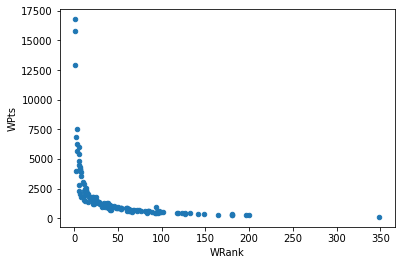

In [37]:
# Tirer aléatoirement 200 entrées .
sample = df_atp.iloc[list(random.sample(range(df_atp.shape[0]), 200)), :]
sample.plot.scatter(x='WRank', y='WPts')

Tout comme on le soupçonne, les points et le rang forment une très jolie fonction quadratique.Donc dans la suite on prend une des deux caractéristiques jmais les deux à la fois


**La date en tant qu'objet datetime n'a aucune utilité, je la remplacerai donc par la différence en jours entre la date de l'entrée et la date la plus ancienne enregistrée dans l'ensemble de données.**

In [38]:
basedate = df_atp.Date.sort_values().values[0]
df_atp['Days'] = list(map(lambda d: (d - basedate).days, df_atp.Date))
df_atp.Days.unique()

array([   0,    7,   14, ..., 6528, 6529, 6530])

In [39]:
odds_L      = ['B365L', 'EXL', 'PSL', 'LBL', 'CBL', 'SJL']
odds_W      = ['B365W', 'EXW', 'PSW', 'LBW', 'CBW', 'SJW']
agg_odds_W  = ['AvgW','MaxW','MinW']
agg_odds_L  = ['AvgL','MaxL','MinL']

player      = ['WRank','LRank','prior_wins_winner','prior_wins_loser']
env         = ["Date","Days",'ATP','Series','Court','Surface'] #Date est gardée juste pour faire le split train/test c'est Days qui nous intérèsse le plus pour l'apprentissage des modèles.
labs        = ['Labs']

columns_fit=env+ player+agg_odds_W+agg_odds_L+labs
df_atp[columns_fit].isnull().sum()

Date                 0
Days                 0
ATP                  0
Series               0
Court                0
Surface              0
WRank                0
LRank                0
prior_wins_winner    0
prior_wins_loser     0
AvgW                 0
MaxW                 0
MinW                 0
AvgL                 0
MaxL                 0
MinL                 0
Labs                 0
dtype: int64

Les caractéristiques sont réparties sur le gagnaint "Winner" et le perdant "Loser" sauf que nous,  on a changé la logique d'annontation pour éviter le bias sur les classes === > il est nécissaire alors de répartir les caractéristiques sur les joueurs en suivant la meme logique (ordre lexcographique sur les 2 joueurs)

In [46]:

columns_fit= env+player+agg_odds_W+agg_odds_L+labs

df_atp_X=df_atp[columns_fit]


df_atp_X["Rank_P1"] = df_atp_X.apply(lambda row: row["WRank"] if row["Labs"] == 1 else row["LRank"], axis=1)
df_atp_X["Rank_P0"] = df_atp_X.apply(lambda row: row["WRank"] if row["Labs"] == 0 else row["LRank"], axis=1)

df_atp_X=df_atp_X.drop("WRank", axis=1)
df_atp_X=df_atp_X.drop("LRank", axis=1)

df_atp_X["prior_wins_P1"] = df_atp_X.apply(lambda row: row["prior_wins_winner"] if row["Labs"] == 1 else row["prior_wins_loser"], axis=1)
df_atp_X["prior_wins_P0"] = df_atp_X.apply(lambda row: row["prior_wins_winner"] if row["Labs"] == 0 else row["prior_wins_loser"], axis=1)

df_atp_X=df_atp_X.drop("prior_wins_winner", axis=1)
df_atp_X=df_atp_X.drop("prior_wins_loser", axis=1)


for col in list(zip((agg_odds_L),(agg_odds_W)))  :
    suffix=col[0][:-1]
    df_atp_X[suffix+"_P1"] = df_atp_X.apply(lambda row: row[col[1]] if row["Labs"] == 1 else row[col[0]], axis=1)
    df_atp_X[suffix+"_P0"] = df_atp_X.apply(lambda row: row[col[1]] if row["Labs"] == 0 else row[col[0]], axis=1)
   
    df_atp_X=df_atp_X.drop(col[0], axis=1)
    df_atp_X=df_atp_X.drop(col[1], axis=1)
    #print(col[0],col[1])
    

df_atp_X

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Days,ATP,Series,Court,Surface,Labs,Rank_P1,Rank_P0,prior_wins_P1,prior_wins_P0,Avg_P1,Avg_P0,Max_P1,Max_P0,Min_P1,Min_P0
2965,2001-01-01,0,1,International,Outdoor,Hard,1,23.0,485.0,0.574468,0.000000,1.1100,3.750000,1.12,4.00,1.10,3.50
2967,2001-01-01,0,1,International,Outdoor,Hard,0,83.0,7.0,0.419355,0.779412,3.5500,1.200000,3.80,1.28,3.30,1.12
2979,2001-01-01,0,1,International,Outdoor,Hard,1,23.0,127.0,0.574468,0.500000,1.2825,2.925000,1.35,3.20,1.20,2.60
2985,2001-01-01,0,1,International,Outdoor,Hard,0,18.0,87.0,0.583333,0.522727,1.4300,2.407500,1.45,2.70,1.41,2.00
2986,2001-01-01,0,1,International,Outdoor,Hard,0,81.0,66.0,0.465116,0.600000,2.2100,1.543333,2.38,1.55,2.00,1.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,2018-11-16,6528,67,Masters Cup,Indoor,Hard,0,10.0,5.0,0.622705,0.664032,3.1400,1.380000,3.40,1.44,3.20,1.36
52294,2018-11-16,6528,67,Masters Cup,Indoor,Hard,0,7.0,1.0,0.652047,0.829876,5.1400,1.170000,6.03,1.22,4.50,1.19
52295,2018-11-17,6529,67,Masters Cup,Indoor,Hard,0,3.0,5.0,0.829142,0.665354,1.3800,3.140000,1.45,3.40,1.36,3.20
52296,2018-11-17,6529,67,Masters Cup,Indoor,Hard,0,6.0,1.0,0.589792,0.830052,6.5200,1.120000,7.72,1.15,7.00,1.11


Encodage des features en catégories (Series, Court, surface)

In [47]:
cat_features=['Series','Court','Surface']

series_map = {}
court_map = {}
surface_map = {}

maps = [series_map, court_map, surface_map]
odds_W = ['B365W', 'EXW', 'PSW', 'LBW', 'CBW', 'SJW', 'IWW', 'UBW', 'SBW', 'GBW', 'B&WW']
odds_L = ['B365L', 'EXL', 'PSL', 'LBL', 'CBL', 'SJL', 'IWL', 'UBL', 'SBL', 'GBL', 'B&WL']
it = 0

for c in df_atp_X.select_dtypes(include=object):
    val = 0
    for u in df_atp_X[c].unique():
        maps[it][u] = val
        val += 1
    df_atp_X[c] = df_atp_X[c].map(maps[it])
    it += 1

encoded_atp=df_atp_X
df_atp_X

,Date,Days,ATP,Series,Court,Surface,Labs,Rank_P1,Rank_P0,prior_wins_P1,prior_wins_P0,Avg_P1,Avg_P0,Max_P1,Max_P0,Min_P1,Min_P0
2965,2001-01-01,0,1,0,0,0,1,23.0,485.0,0.574468,0.000000,1.1100,3.750000,1.12,4.00,1.10,3.50
2967,2001-01-01,0,1,0,0,0,0,83.0,7.0,0.419355,0.779412,3.5500,1.200000,3.80,1.28,3.30,1.12
2979,2001-01-01,0,1,0,0,0,1,23.0,127.0,0.574468,0.500000,1.2825,2.925000,1.35,3.20,1.20,2.60
2985,2001-01-01,0,1,0,0,0,0,18.0,87.0,0.583333,0.522727,1.4300,2.407500,1.45,2.70,1.41,2.00
2986,2001-01-01,0,1,0,0,0,0,81.0,66.0,0.465116,0.600000,2.2100,1.543333,2.38,1.55,2.00,1.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52293,2018-11-16,6528,67,4,1,0,0,10.0,5.0,0.622705,0.664032,3.1400,1.380000,3.40,1.44,3.20,1.36
52294,2018-11-16,6528,67,4,1,0,0,7.0,1.0,0.652047,0.829876,5.1400,1.170000,6.03,1.22,4.50,1.19
52295,2018-11-17,6529,67,4,1,0,0,3.0,5.0,0.829142,0.665354,1.3800,3.140000,1.45,3.40,1.36,3.20
52296,2018-11-17,6529,67,4,1,0,0,6.0,1.0,0.589792,0.830052,6.5200,1.120000,7.72,1.15,7.00,1.11


S'il exsite des chamaps entièrement rempli par une valeur unique, alors il est préfirable de les éliminer 

In [48]:
#encoded_atp = encoded_atp.loc[:,encoded_atp.apply(pd.Series.nunique) != 1]
df_atp_X = df_atp_X.loc[:,df_atp_X.apply(pd.Series.nunique) != 1]

**Retour à la corrélation :**  On trace la matrice de corrélation entre les différentes caractérisqtues , et on élimine une des deux caractéristiques dont **la coef de corrélation** est supérieur à un certain seuil par exemple **coef =7/8**  ===> ainsi on garde que les caractéristiques indépendantes 

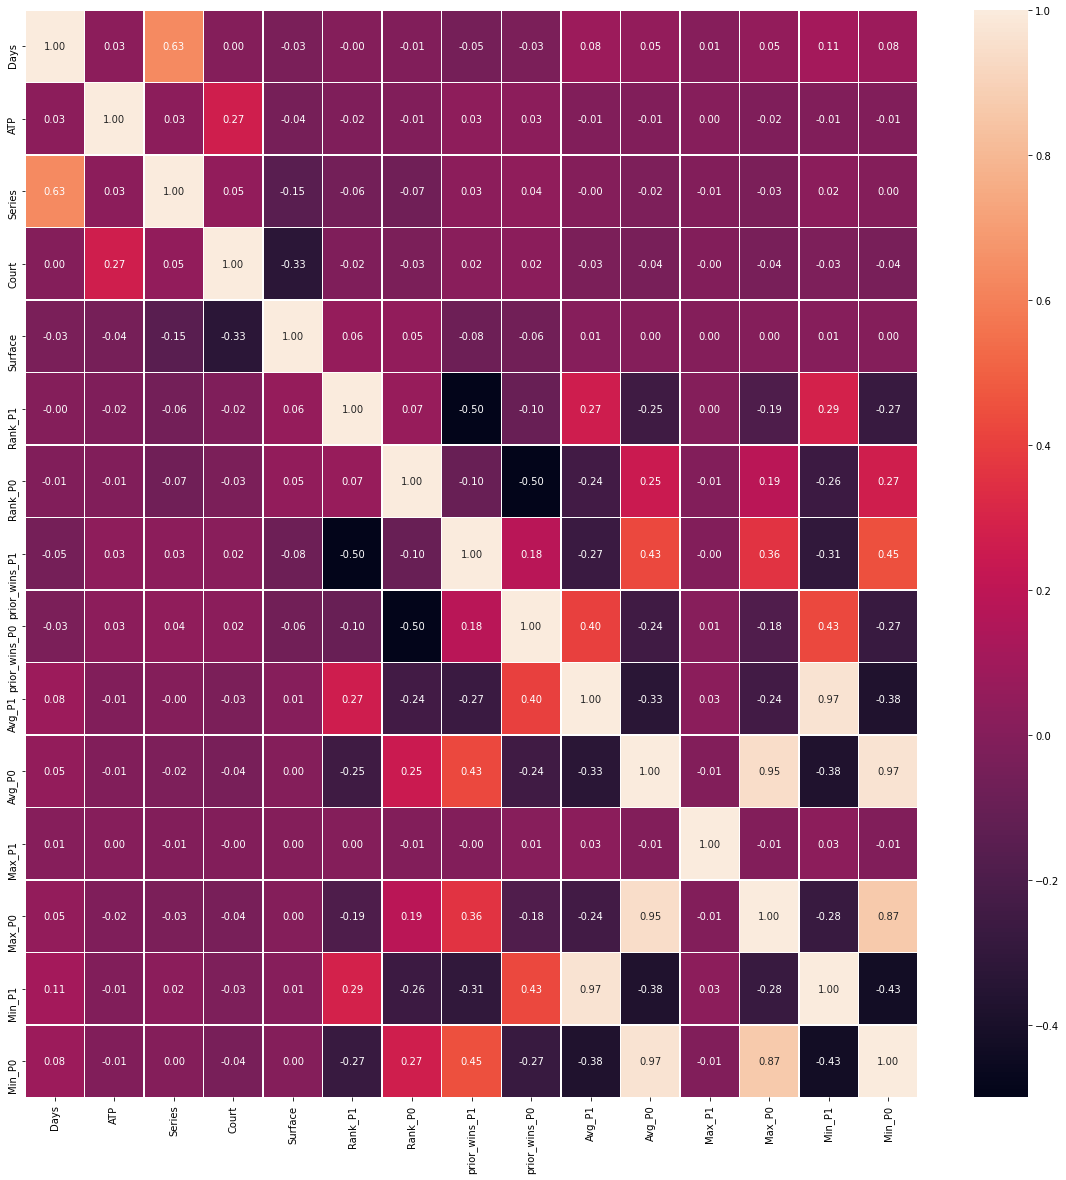

In [51]:
f,ax = plt.subplots(figsize=(20, 20))
#sns.heatmap(encoded_atp.drop("Labs", axis=1).corr(), linewidths=.5, fmt= '.5f',ax=ax)
sns.heatmap(df_atp_X.drop("Labs", axis=1).corr(),annot=True, linewidths=.5, fmt= '.2f',ax=ax)

On remarque bien que la corrélation est élévée entre les champs des cotes et leurs agrégations par exemple corr(AvgP1,B365p0) =0.96 ...etc . Il est intérissant si on les élimine

In [50]:
corr_coef=0.95
corr_m = df_atp_X.drop("Labs", axis=1).corr().abs()
upper = corr_m.where(np.triu(np.ones(corr_m.shape), k=1).astype(np.bool))

correlated = [column for column in upper.columns if any(upper[column] > corr_coef)]
print("caractérstiques supprimées:  ",correlated)
# Drop features 
df_atp_X.drop(correlated, axis=1, inplace=True)



caractérstiques supprimées:   ['Min_P1', 'Min_P0']


On remarque que il y une forte corrélation entre Min_p0 ,Min_p1 et resepctivement Avg_p0 et Avg_p1 ce qui est logique car les quatres champs représentent des agrégations sur les valeurs des cotes 'odds'

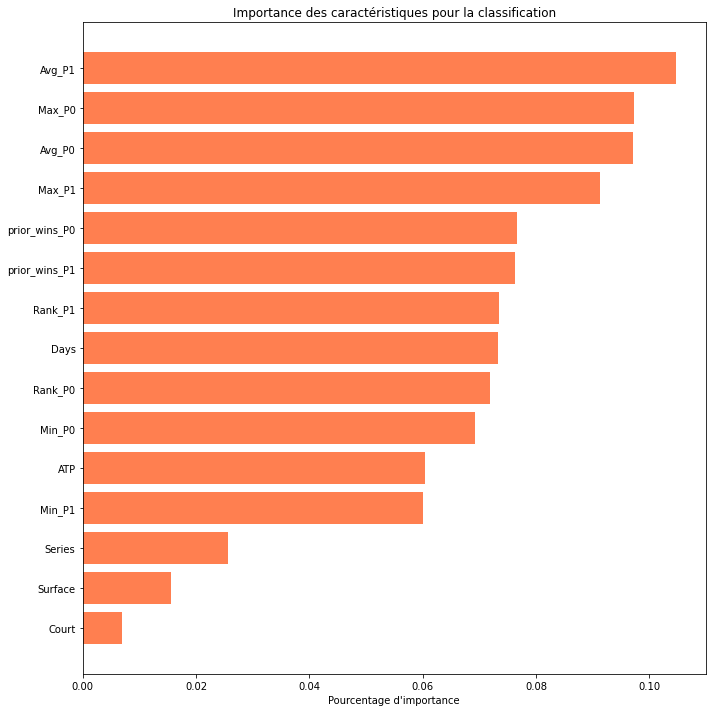

In [52]:
feat_forest = RandomForestClassifier(n_jobs=-1)
feat_forest.fit(X=encoded_atp.drop(["Labs","Date"], axis=1), y=encoded_atp.loc[:, "Labs"])

plt.figure(figsize=(10, 10))
feat_imp = feat_forest.feature_importances_
cols = df_atp_X.columns.drop(['Date','Labs'])

feat_imp, cols = zip(*sorted(zip(feat_imp, cols)))

plt.barh(range(len(cols)), feat_imp, align="center", color='coral');
plt.yticks(range(len(cols)), cols)
plt.title("Importance des caractéristiques pour la classification")
plt.xlabel("Pourcentage d'importance")
plt.tight_layout();

Les chmaps les plus discriminant pour un randomForest sont les agrégation sur les valeurs des cotes et l'historique du passé des deux joueurs et la dimension topmprelle (Days) 

## Apprentissage et évaluation des modèles :

### Split des données en Train (<2017) validation (=2018) et test (=2017)

Il faut faire bien attention lors du split des données car les données présentent une dimmension temporelle, sur ce genre de données il faut toujours veuiller à conserver l'ordre des séries surtout pas faie une cross validation non étudié. Je propose donc de les diviser d'une manière à ce que les données en train représentent le passé (ordre chrologique respécté) des données utilisées en test.

In [53]:
year_to_predict = 2017
year_to_val     = 2018

df_train = df_atp_X.loc[df_atp[df_atp["Date"].dt.year <  year_to_predict].index]
df_test  = df_atp_X.loc[df_atp[df_atp["Date"].dt.year == year_to_predict].index]
df_val   = df_atp_X.loc[df_atp[df_atp["Date"].dt.year == year_to_val].index]


X_train = df_train.drop(["Labs","Date"], axis=1)
y_train = df_train["Labs"]

X_val = df_val.drop(["Labs","Date"], axis=1)
y_val = df_val["Labs"]

X_test = df_test.drop(["Labs","Date"], axis=1)
y_test = df_test["Labs"]

print("Ensemble de Train ",X_train.shape,  y_train.shape)
print("Ensemble de Validation ",X_val.shape,  y_val.shape)
print("Ensemble de Test:     ",X_test.shape,  y_test.shape)



Ensemble de Train  (42166, 15) (42166,)
Ensemble de Validation  (2590, 15) (2590,)
Ensemble de Test:      (2576, 15) (2576,)


In [55]:
!pip install catboost
from catboost import CatBoostClassifier 

In [56]:
sc = StandardScaler()  
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)


**Métrics d'évaluation :**

Il s'agit bien d'un problème de classification binaire on propose alors


*  **Accuracy** , **Recall** , **Precision** , **Score F1** et **Score Auc**  comme métrics d'evaluation des modèles.
*   **Log_loss** comme fonction de calcul de cout d'erreur (entre y_predict et y)



In [75]:
def classification_reportUD(y_true, y_pred, name_classifiers, train_time=None):
  assert(len(y_pred) == len(name_classifiers))
  assert(len(train_time) == len(name_classifiers) if train_time else True)
  
  reports = []
  metrics = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score", "Auc_score", "Log_loss"]
  if train_time:
    metrics = metrics + ["Temps d'apprentissage "]

  for idx, y_clf in enumerate(y_pred):
    acc = accuracy_score(y_true, y_clf)
    pre = precision_score(y_true, y_clf)
    rec = recall_score(y_true, y_clf)
    f1s = f1_score(y_true, y_clf)
    auc = mts.roc_auc_score(y_true,y_clf, average='macro', sample_weight=None)
    loss= log_loss(y_true,y_clf)

    report = (name_classifiers[idx], acc, pre, rec, f1s,auc, loss)
   
    if train_time:
      report = report + (train_time[idx], )
    reports.append(report)
        
  display(pd.DataFrame.from_records(reports, columns=metrics))


In [62]:
names_of_classifiers = ["Catboost", "AdaBoost","Random Forest_estim_31", "Random Forest_estim_300", "Decision Tree","Linear SVM","K-NN"]

classifiers = [
    CatBoostClassifier(iterations=200,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           verbose=False),

    RandomForestClassifier(n_estimators= 31, criterion="gini", bootstrap = False, max_depth=4, max_features = 'auto',class_weight="balanced"),
    RandomForestClassifier(n_estimators= 300, criterion="gini", bootstrap = True, max_depth=4, max_features = 'auto',class_weight="balanced"),
    DecisionTreeClassifier(max_depth=9),
    SVC(kernel="linear", C=0.03),
    KNeighborsClassifier(6, n_jobs=-1),
    AdaBoostClassifier()]

y_pred = []
y_pred_test = []
train_time = []

for name, classifier in zip(names_of_classifiers, classifiers):
    
    tic = time()
    classifier.fit(X_train_scaled,y_train)
    tac = time()

    y_predict=classifier.predict(X_test_scaled)
    y_Train_predict=classifier.predict(X_train_scaled)
    
    y_pred.append(y_Train_predict)
    y_pred_test.append(y_predict)
    train_time.append(tac - tic)
    
    print("Modèle : {} ===> Temps d'apprentissage: {} sec".format(name, train_time[-1]))

    

Modèle : Catboost ===> Temps d'apprentissage: 4.638839960098267 sec
Modèle : AdaBoost ===> Temps d'apprentissage: 1.1780672073364258 sec
Modèle : Random Forest_estim_31 ===> Temps d'apprentissage: 8.000416040420532 sec
Modèle : Random Forest_estim_300 ===> Temps d'apprentissage: 0.32866811752319336 sec
Modèle : Decision Tree ===> Temps d'apprentissage: 37.89828634262085 sec
Modèle : Linear SVM ===> Temps d'apprentissage: 0.10045671463012695 sec
Modèle : K-NN ===> Temps d'apprentissage: 2.5967166423797607 sec


### Evaluation des modèles en Apprentissage

In [77]:
#rapport d'evaluation en apprentssage
classification_reportUD(y_train, y_pred, names_of_classifiers, train_time)

,Classifier,Accuracy,Precision,Recall,F1-Score,Auc_score,Log_loss,Temps d'apprentissage
0,Catboost,0.719490,0.722475,0.727196,0.724828,0.719364,9.688598,4.638840
1,AdaBoost,0.703292,0.709110,0.705303,0.707201,0.703259,10.248057,1.178067
2,Random Forest_estim_31,0.703268,0.710858,0.701102,0.705946,0.703303,10.248875,8.000416
3,Random Forest_estim_300,0.720272,0.722672,0.729250,0.725946,0.720126,9.661568,0.328668
4,Decision Tree,0.692216,0.662123,0.804920,0.726572,0.690375,10.630633,37.898286
5,Linear SVM,0.744700,0.805481,0.655868,0.723016,0.746151,8.817831,0.100457
6,K-NN,0.703481,0.705953,0.713565,0.709739,0.703317,10.241508,2.596717


### Evaluation des modèles en test : 


In [79]:
#rapport d'evaluation en apprentssage
classification_reportUD(y_test, y_pred_test, names_of_classifiers)

,Classifier,Accuracy,Precision,Recall,F1-Score,Auc_score,Log_loss
0,Catboost,0.679736,0.697512,0.672918,0.684994,0.679983,11.061647
1,AdaBoost,0.680124,0.695920,0.678170,0.686930,0.680195,11.048241
2,Random Forest_estim_31,0.680124,0.696829,0.675919,0.686215,0.680276,11.048240
3,Random Forest_estim_300,0.644022,0.661240,0.639910,0.650400,0.644171,12.295189
4,Decision Tree,0.675466,0.660426,0.767442,0.709924,0.672136,11.209176
5,Linear SVM,0.635481,0.687262,0.542386,0.606289,0.638852,12.590130
6,K-NN,0.681289,0.698758,0.675169,0.686761,0.681510,11.008015


### Apprentissage et évaluation d'un modèle de type réseau de neuronnes : (**Keras**)

On utilise comme fonction de cout d'erreur la CrossEntropy Loss qu'on juge adéquate à la classification.

---> Inmplémentation avec un **checkpointing**

In [92]:
network = models.Sequential()
network.add(layers.Dense(units=64, activation='relu', input_shape=(len(X_train.columns),)))
network.add(layers.Dense(units=32, activation='relu'))
network.add(layers.Dense(units=16, activation='relu'))
network.add(layers.Dense(units=1, activation='sigmoid'))

network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=500)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)

!rm 'best_model.h5'
history = network.fit(X_train, y_train, 
            epochs=500, verbose=0, batch_size=130, 
            validation_data=(X_val, y_val), callbacks=[es, mc]) 



Epoch 00001: val_loss improved from inf to 0.64796, saving model to best_model.h5

Epoch 00002: val_loss did not improve from 0.64796

Epoch 00003: val_loss did not improve from 0.64796

Epoch 00004: val_loss did not improve from 0.64796

Epoch 00005: val_loss did not improve from 0.64796

Epoch 00006: val_loss did not improve from 0.64796

Epoch 00007: val_loss did not improve from 0.64796

Epoch 00008: val_loss did not improve from 0.64796

Epoch 00009: val_loss did not improve from 0.64796

Epoch 00010: val_loss did not improve from 0.64796

Epoch 00011: val_loss did not improve from 0.64796

Epoch 00012: val_loss did not improve from 0.64796

Epoch 00013: val_loss did not improve from 0.64796

Epoch 00014: val_loss did not improve from 0.64796

Epoch 00015: val_loss did not improve from 0.64796

Epoch 00016: val_loss did not improve from 0.64796

Epoch 00017: val_loss did not improve from 0.64796

Epoch 00018: val_loss did not improve from 0.64796

Epoch 00019: val_loss improved f

In [86]:
saved_model=load_model('best_model.h5')

In [87]:
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc =  saved_model.evaluate(X_test, y_test, verbose=0)

print('Accuracy en Train: %.3f,Accuracy en Test: %.3f' % (train_acc, test_acc))

Accuracy en Train: 0.703,Accuracy en Test: 0.679


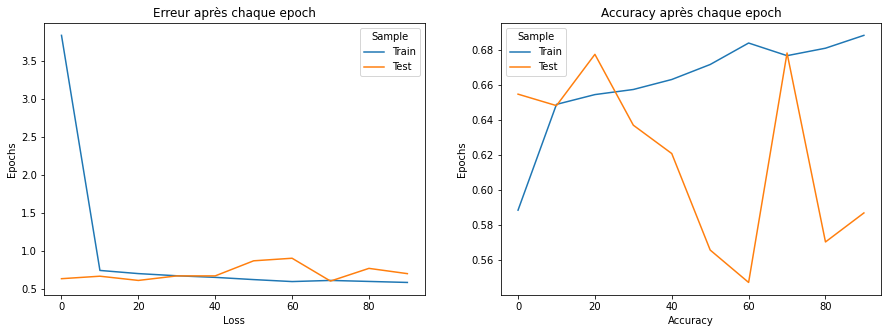

In [91]:


plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Erreur après chaque epoch')
plt.plot(history.epoch[::10], history.history['loss'][::10], label='Train')
plt.plot(history.epoch[::10], history.history['val_loss'][::10], label='Test')
plt.legend(['Train', 'Test'],loc='upper right', title='Sample', facecolor='white',fancybox=True)
plt.xlabel('Loss')
plt.ylabel('Epochs')

plt.subplot(1, 2, 2)
plt.title('Accuracy après chaque epoch')
plt.plot(history.epoch[::10], history.history['accuracy'][::10], label='Train')
plt.plot(history.epoch[::10], history.history['val_accuracy'][::10], label='Test')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left', title='Sample', facecolor='white', fancybox=True)



### Axes d'amélioration:



*   Ajouter des features pertinentes décrivant en détails les performances des joueurs tels que : le pourcentage du gain sur des terrain de type : grass, hard ... etc. Pourcentage des points reportées à un ensemble données par type de terrain.

*  Ces features peuvent améliorer l'accuracy des modèles surtout celle des réseau de neuronnes 

*  Mais on s'attend pas à une **Accuracy** qui dépasse 0.75 par ce que il y toujours un facteur aléatoire qui influence les résultats des matchs malgré les informations à priori portant soit sue les cotes, les performances des joueurs, ou vir meme l'environement du jeu.



## FIN